nodes:  1000 links  2974
Generation 0: Min Fitness 120871995.87964208
Generation 1: Min Fitness 120871721.46407823
Generation 2: Min Fitness 120852164.91294912
Generation 3: Min Fitness 120834721.1252124
Generation 4: Min Fitness 120818909.56445925
Generation 5: Min Fitness 120791713.15426978
Generation 6: Min Fitness 120789919.83159043
Generation 7: Min Fitness 120720950.2470281
Generation 8: Min Fitness 120720950.2470281
Generation 9: Min Fitness 120648312.77643229
Generation 10: Min Fitness 120648566.00472237
Generation 11: Min Fitness 120649826.03216906
Generation 12: Min Fitness 120590560.9389085
Generation 13: Min Fitness 120584064.03641467
Generation 14: Min Fitness 120557454.23833522
Generation 15: Min Fitness 120525460.16080993
Generation 16: Min Fitness 120498951.67619853
Generation 17: Min Fitness 120495268.8956843
Generation 18: Min Fitness 120471686.0002856
Generation 19: Min Fitness 120442633.51387787


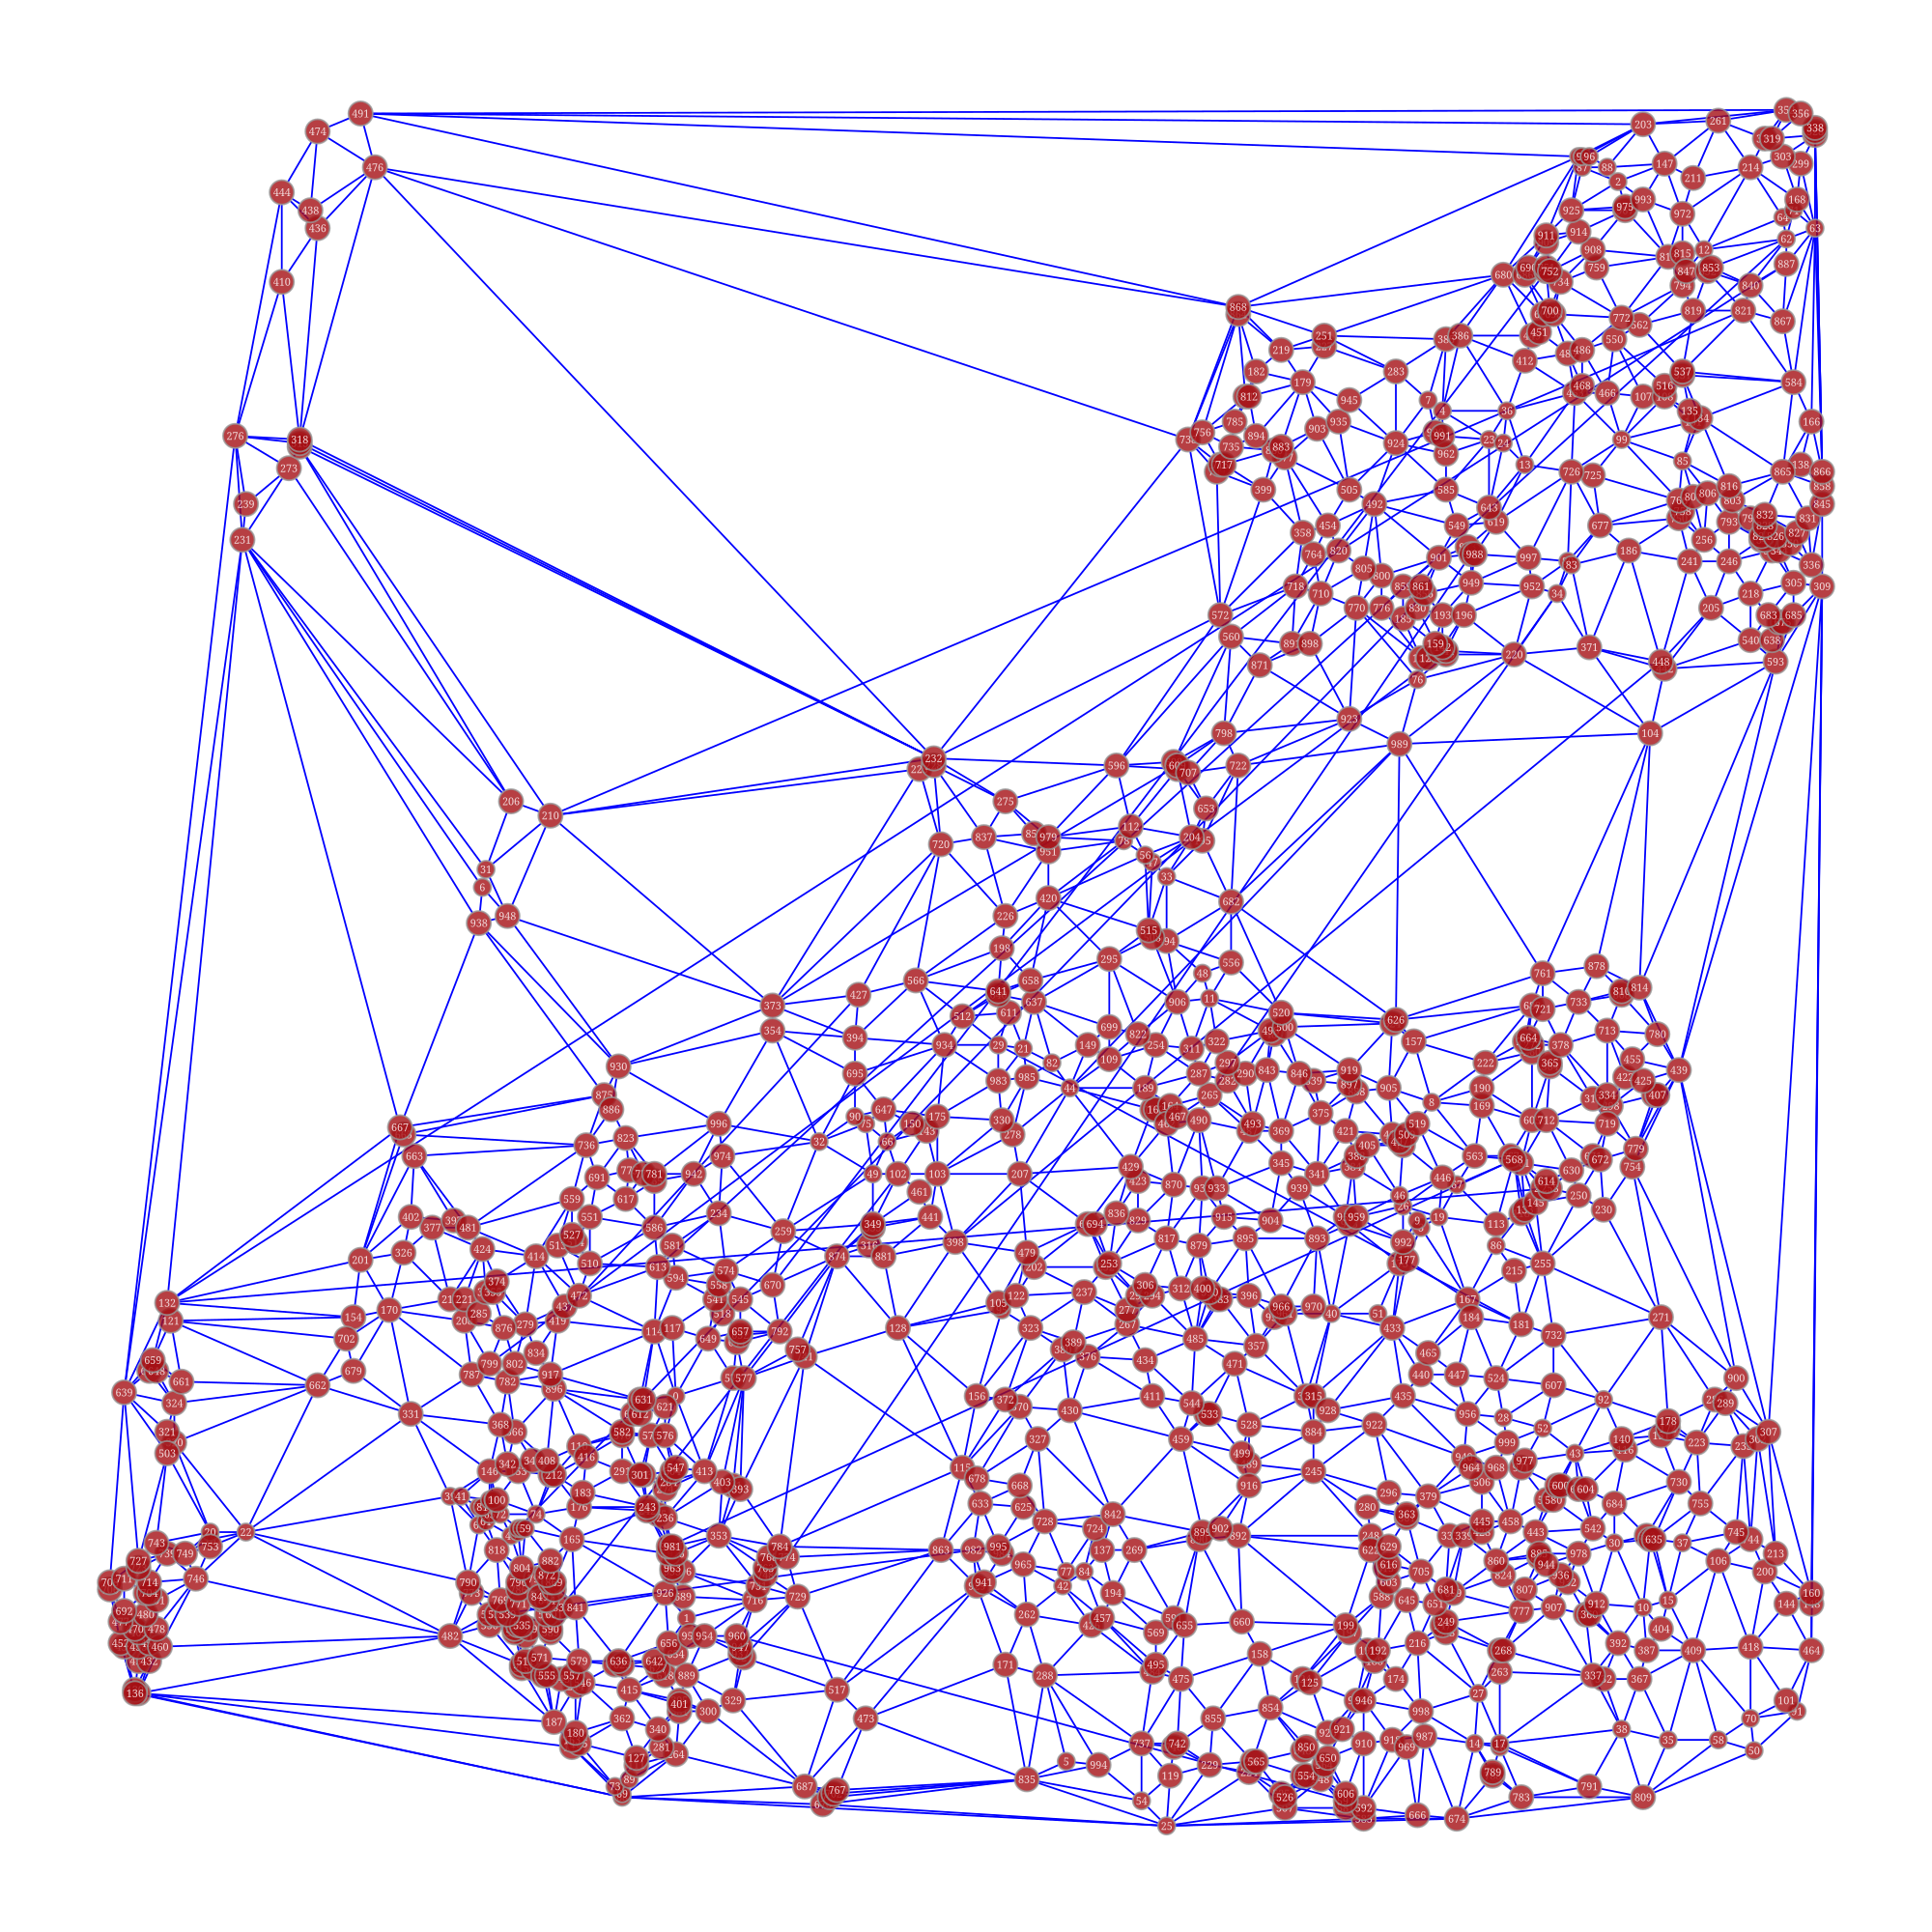

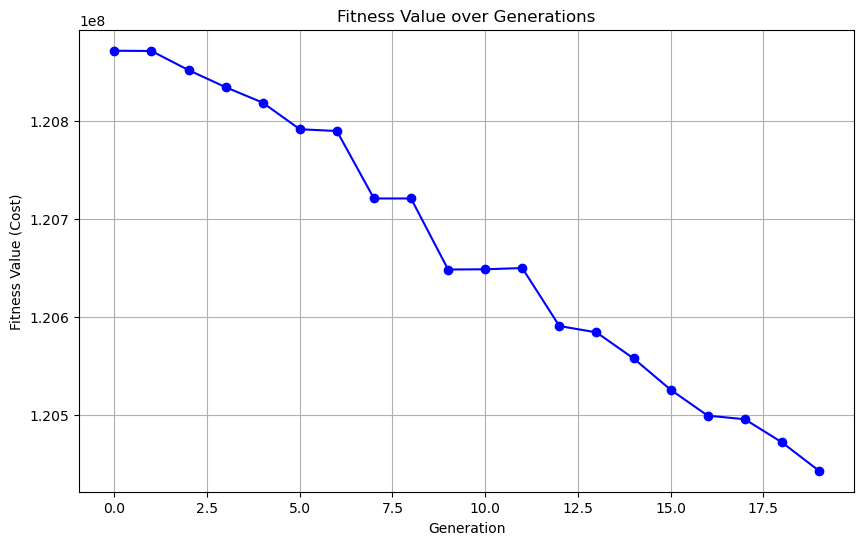

In [1]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取日本城市人口网络数据 グラフと位置情報を読み取る
city = 'fukuoka'
sort = 'ascend'
scale = '1000'
types = 'dt'
read_graph, read_pos = fo.read_files(f"../networks_clusters/{city}_{sort}_{scale}_{types}.net", True)
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance

# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual

# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights

# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数与原始图相同
        return float('inf'),  # 如果边数不相同，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,

# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > read_graph.num_edges():
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - read_graph.num_edges())
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < read_graph.num_edges():
            # 添加缺失的边
            missing_edges = random.sample(non_edges, read_graph.num_edges() - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2

# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,

# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)

# 初始化个体时确保边数与原始图相同
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = graph_to_individual(read_graph)
    return creator.Individual(individual)

toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)

# 主遗传算法流程
def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(20):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof

if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
               output=f'./output_O/{city}_{sort}_{scale}_{types}_optimized.png')

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations.png")
    plt.show()


nodes:  1000 links  2974


/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/huanghanjun/anaconda3/envs/graph-tool/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Generation 0: Min Fitness 120918712.47298218
Generation 1: Min Fitness 120758974.92960204
Generation 2: Min Fitness 120758974.92960204
Generation 3: Min Fitness 120758974.92960204
Generation 4: Min Fitness 120722672.00791404
Generation 5: Min Fitness 120680469.73425598
Generation 6: Min Fitness 120673683.13520712
Generation 7: Min Fitness 120659771.05518454
Generation 8: Min Fitness 120644427.25710137
Generation 9: Min Fitness 120607273.23599057
Generation 10: Min Fitness 120574819.2641522
Generation 11: Min Fitness 120572436.07049388
Generation 12: Min Fitness 120537883.14024772
Generation 13: Min Fitness 120533812.75780594
Generation 14: Min Fitness 120502624.8414
Generation 15: Min Fitness 120479940.26693536
Generation 16: Min Fitness 120455963.68732727
Generation 17: Min Fitness 120419066.52954316
Generation 18: Min Fitness 120389201.51049143
Generation 19: Min Fitness 120376874.8716635
Generation 20: Min Fitness 120356748.15626478
Generation 21: Min Fitness 120332622.97517952
Gene

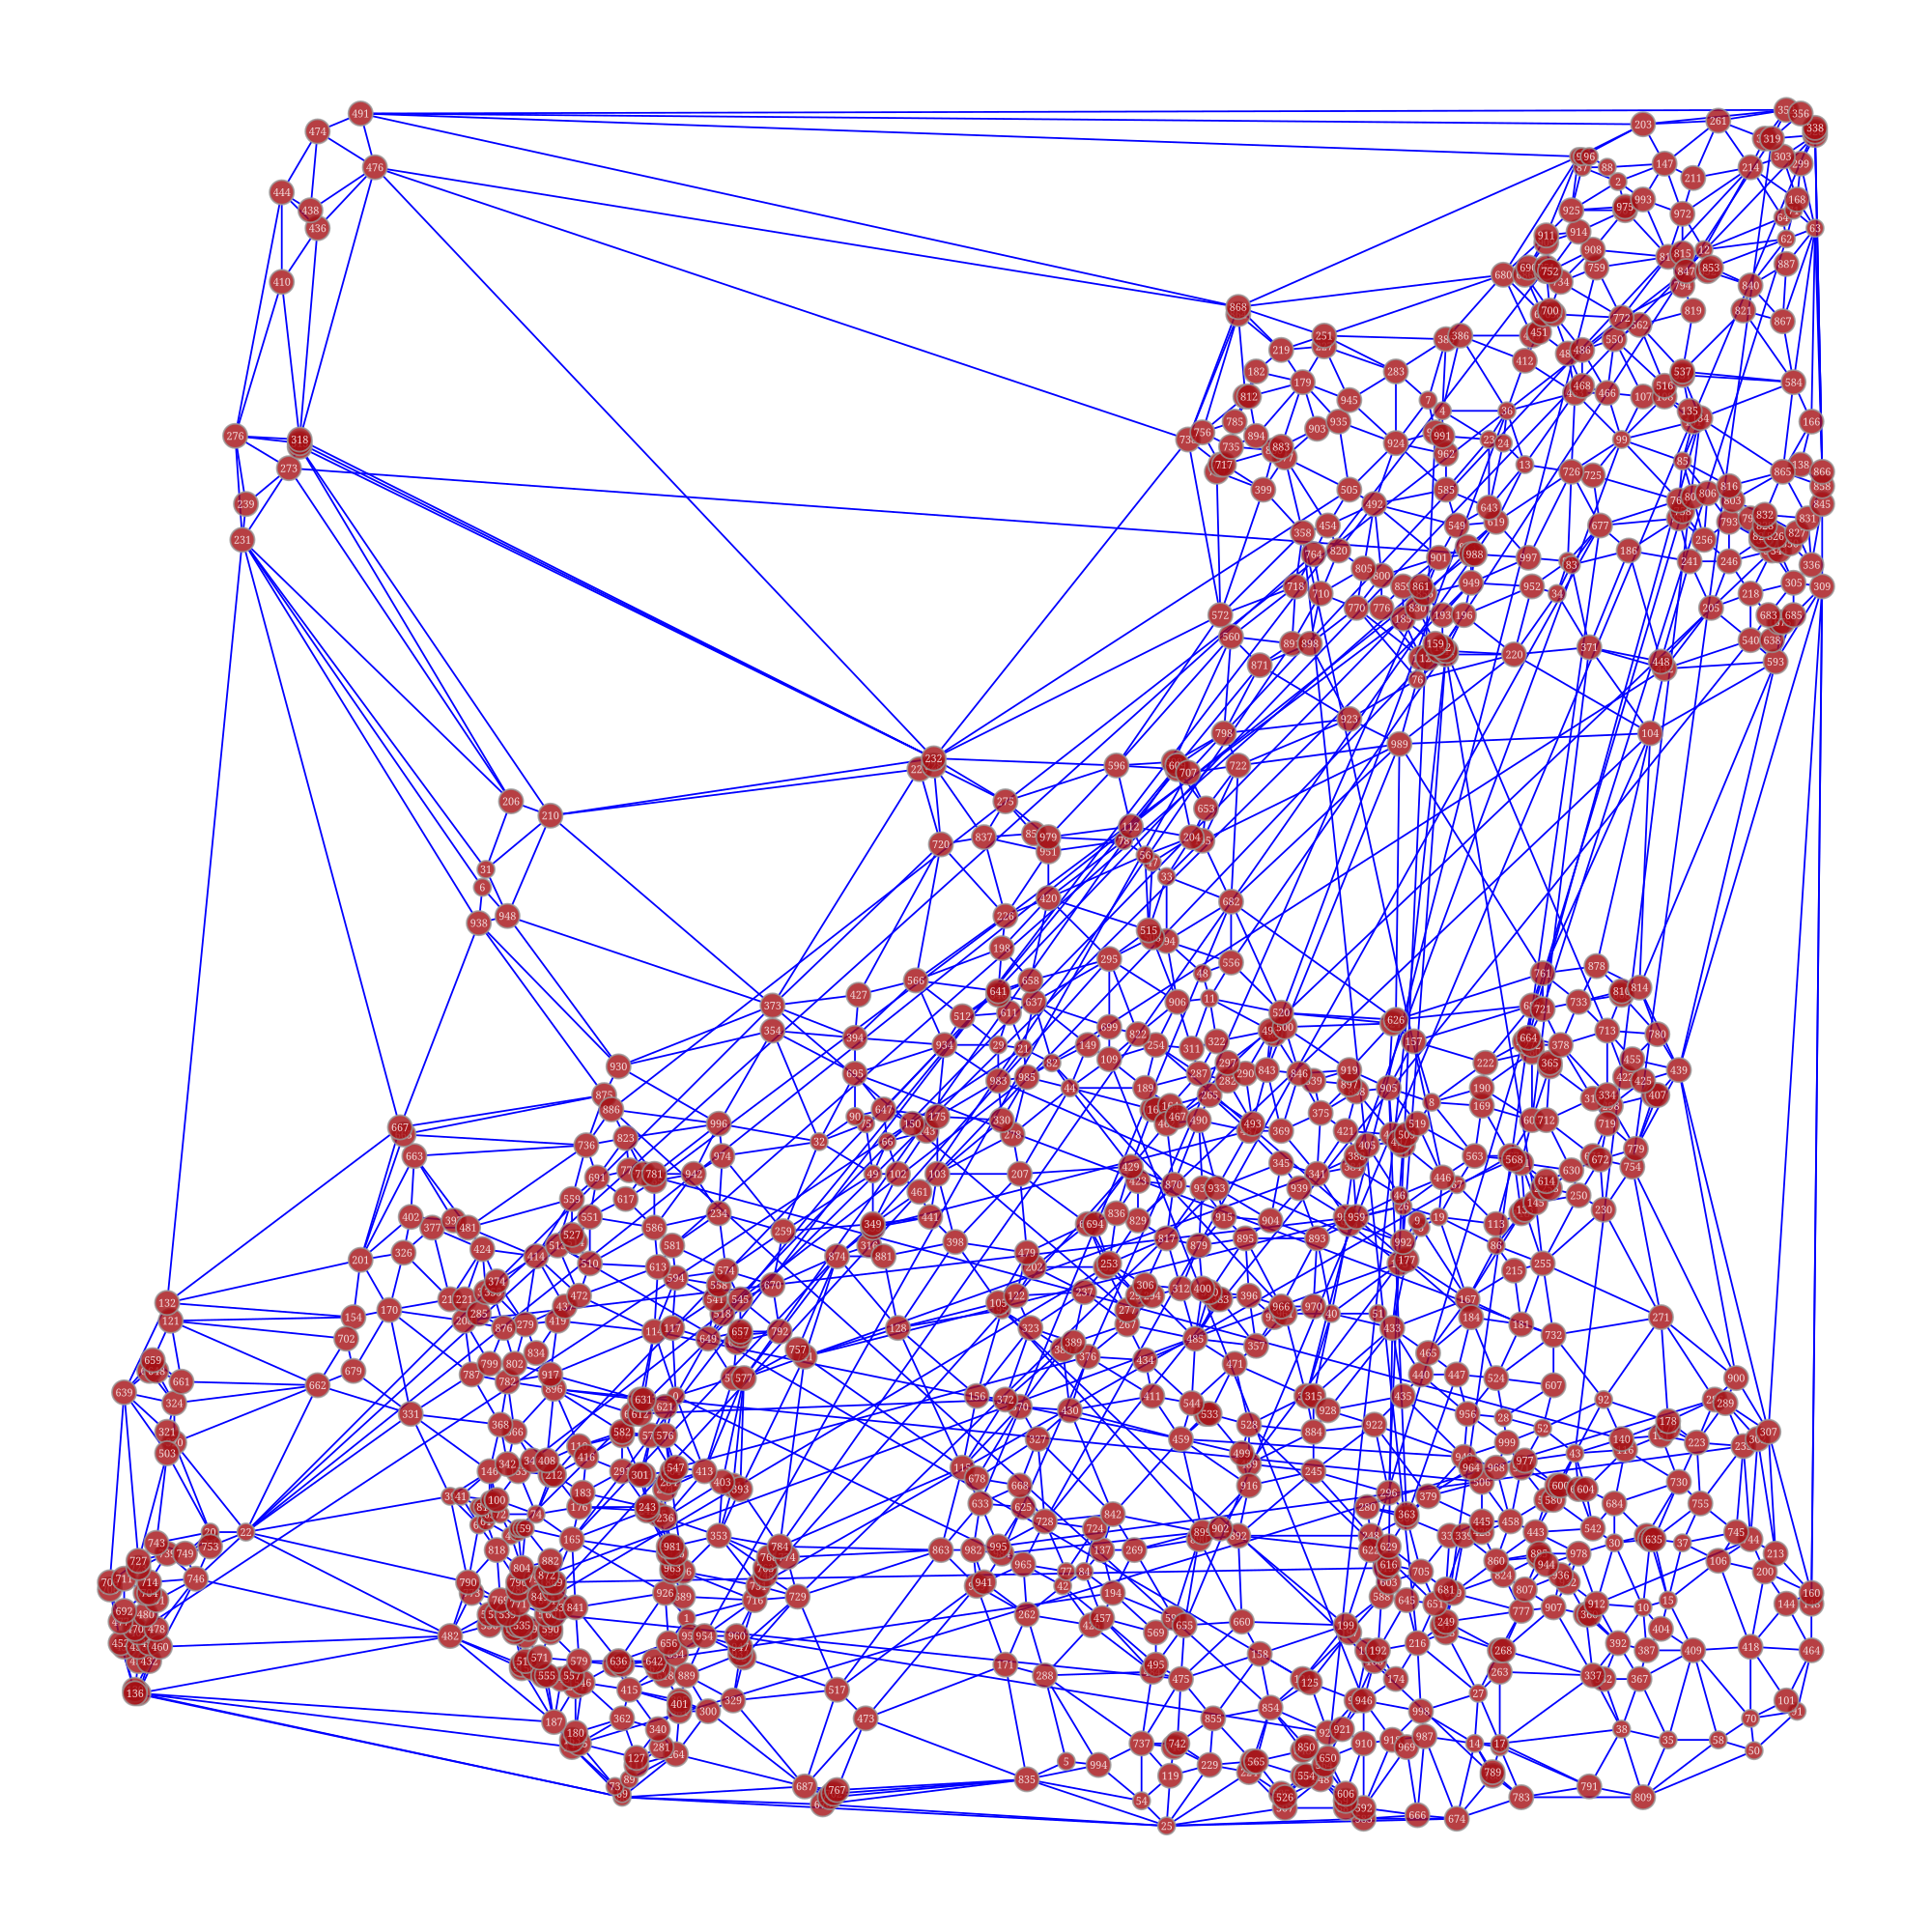

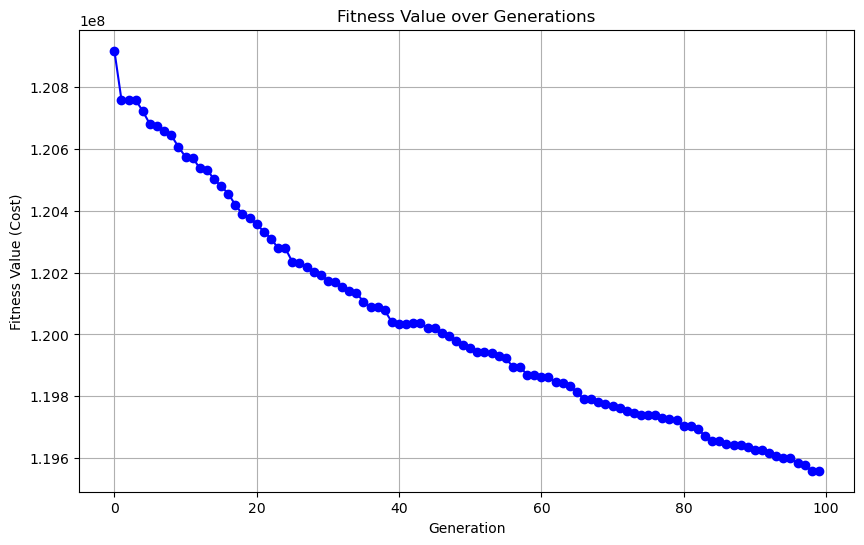

In [2]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取日本城市人口网络数据 グラフと位置情報を読み取る
city = 'fukuoka'
sort = 'ascend'
scale = '1000'
types = 'dt'
read_graph, read_pos = fo.read_files(f"../networks_clusters/{city}_{sort}_{scale}_{types}.net", True)
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数与原始图相同
        return float('inf'),  # 如果边数不相同，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > read_graph.num_edges():
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - read_graph.num_edges())
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < read_graph.num_edges():
            # 添加缺失的边
            missing_edges = random.sample(non_edges, read_graph.num_edges() - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数与原始图相同
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = graph_to_individual(read_graph)
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(100):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
               output=f'./output_O/{city}_{sort}_{scale}_{types}_optimized.png')

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations.png")
    plt.show()


In [ ]:
import numpy as np
import random
from graph_tool.all import Graph, shortest_distance, graph_draw
from deap import base, creator, tools, algorithms
import python_codes.files_operators as fo
import matplotlib.pyplot as plt

# 读取日本城市人口网络数据 グラフと位置情報を読み取る
city = 'fukuoka'
sort = 'ascend'
scale = '1000'
types = 'dt'
read_graph, read_pos = fo.read_files(f"../networks_clusters/{city}_{sort}_{scale}_{types}.net", True)
print("nodes: ", read_graph.num_vertices(), "links ", read_graph.num_edges())

# 计算并添加边的欧氏距离作为权重属性
edge_weights = read_graph.new_edge_property("double")
for edge in read_graph.edges():
    source_pos = read_pos[edge.source()]
    target_pos = read_pos[edge.target()]
    euclidean_distance = np.sqrt((source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
    edge_weights[edge] = euclidean_distance


# 将图转换为个体编码
def graph_to_individual(graph):
    num_vertices = graph.num_vertices()
    individual = [0] * (num_vertices * num_vertices)
    for edge in graph.edges():
        source, target = int(edge.source()), int(edge.target())
        individual[source * num_vertices + target] = 1
        individual[target * num_vertices + source] = 1
    return individual


# 将个体解码为图并计算边权重属性
def individual_to_graph(individual, num_vertices):
    graph = Graph(directed=False)
    graph.add_vertex(num_vertices)
    new_edge_weights = graph.new_edge_property("double")
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if individual[i * num_vertices + j] == 1:
                edge = graph.add_edge(graph.vertex(i), graph.vertex(j))
                source_pos = read_pos[graph.vertex(i)]
                target_pos = read_pos[graph.vertex(j)]
                euclidean_distance = np.sqrt(
                    (source_pos[0] - target_pos[0]) ** 2 + (source_pos[1] - target_pos[1]) ** 2)
                new_edge_weights[edge] = euclidean_distance
    return graph, new_edge_weights


# 定义适应度函数
def evaluate(individual):
    graph, new_edge_weights = individual_to_graph(individual, read_graph.num_vertices())
    num_edges = graph.num_edges()
    if num_edges != read_graph.num_edges():  # 边数限制，确保边数与原始图相同
        return float('inf'),  # 如果边数不相同，适应度设为无穷大
    dist_matrix = shortest_distance(graph, weights=new_edge_weights).get_2d_array(range(graph.num_vertices()))
    total_distance = np.sum(dist_matrix[dist_matrix != np.inf])
    return total_distance,


# 自定义交叉操作
def cxGraph(ind1, ind2):
    size = len(ind1)
    point = random.randint(1, size - 1)
    new_ind1 = creator.Individual(np.concatenate((ind1[:point], ind2[point:])))
    new_ind2 = creator.Individual(np.concatenate((ind2[:point], ind1[point:])))

    # 修正边数
    def fix_edges(individual):
        num_vertices = int(np.sqrt(len(individual)))
        edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                 individual[i * num_vertices + j] == 1]
        non_edges = [(i, j) for i in range(num_vertices) for j in range(i + 1, num_vertices) if
                     individual[i * num_vertices + j] == 0]
        if len(edges) > read_graph.num_edges():
            # 移除多余的边
            extra_edges = random.sample(edges, len(edges) - read_graph.num_edges())
            for i, j in extra_edges:
                individual[i * num_vertices + j] = 0
                individual[j * num_vertices + i] = 0
        elif len(edges) < read_graph.num_edges():
            # 添加缺失的边
            missing_edges = random.sample(non_edges, read_graph.num_edges() - len(edges))
            for i, j in missing_edges:
                individual[i * num_vertices + j] = 1
                individual[j * num_vertices + i] = 1
        return individual

    new_ind1 = fix_edges(new_ind1)
    new_ind2 = fix_edges(new_ind2)

    return new_ind1, new_ind2


# 自定义变异操作
def mutGraph(ind):
    size = int(np.sqrt(len(ind)))
    edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 1]
    non_edges = [(i, j) for i in range(size) for j in range(i + 1, size) if ind[i * size + j] == 0]

    if edges and non_edges:
        # 移除一条边
        i, j = random.choice(edges)
        ind[i * size + j] = 0
        ind[j * size + i] = 0

        # 添加一条边
        i, j = random.choice(non_edges)
        ind[i * size + j] = 1
        ind[j * size + i] = 1

    return ind,


# 遗传算法设置
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)


# 初始化个体时确保边数与原始图相同
def initIndividual():
    num_vertices = read_graph.num_vertices()
    individual = graph_to_individual(read_graph)
    return creator.Individual(individual)


toolbox.register("individual", initIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", cxGraph)
toolbox.register("mutate", mutGraph)
toolbox.register("select", tools.selTournament, tournsize=3)


# 主遗传算法流程
def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)

    logbook = tools.Logbook()
    logbook.header = ["gen", "min"]

    for gen in range(300):
        pop, _ = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, stats=stats, halloffame=hof,
                                     verbose=False)
        record = stats.compile(pop)
        logbook.record(gen=gen, **record)
        print(f"Generation {gen}: Min Fitness {record['min']}")

    return pop, logbook, hof


if __name__ == "__main__":
    pop, logbook, hof = main()
    best_individual = hof[0]
    best_graph, _ = individual_to_graph(best_individual, read_graph.num_vertices())

    # 为每个节点标上对应的序号
    vertex_text = best_graph.new_vertex_property("string")
    for v in best_graph.vertices():
        vertex_text[v] = str(int(v))

    # 绘制最终优化后的图
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000))
    graph_draw(best_graph, read_pos, vertex_text=vertex_text, edge_color='blue', output_size=(1000, 1000),
               output=f'./output_O/{city}_{sort}_{scale}_{types}_optimized.png')

    # 绘制适应度值随迭代次数变化的图表
    min_fitness_values = logbook.select("min")
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(min_fitness_values)), min_fitness_values, marker='o', linestyle='-', color='b')
    plt.title("Fitness Value over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness Value (Cost)")
    plt.grid(True)
    plt.savefig(f"./output_O/fitness_over_generations.png")
    plt.show()


nodes:  1000 links  2974
Generation 0: Min Fitness 120852076.98855166
Generation 1: Min Fitness 120794927.77985214
